In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import gym
from gym_utils_q_learning import AtariEnv
from gym_utils_q_learning import AtariFrame
from AtariCNNModel import AtariModel
import numpy as np
import random

#environment_name = "SpaceInvaders-v4"
environment_name  = "SpaceInvadersNoFrameskip-v4"

# environment_name = "Pong-v4"
# typical_bad_game_frame_count = 1100
# reward_frame_shift = -1

action_count = gym.make(environment_name).action_space.n

In [2]:
#play a quick game to test out gym_utils

if False:

    atari_env = AtariEnv(environment_name)
    model = AtariModel(action_count)
    model = model.cuda()
    action = atari_env.env.action_space.sample()

    for i in range(4000):
        atari_frame = atari_env.step(action)
        if atari_frame is None:
            break
        processed_frames = atari_frame.get_next_processed_frames()
        #print("processed_frames.shape: {}".format(processed_frames.shape))
        processed_frames = np.reshape(processed_frames, (1,)+processed_frames.shape)
        #print("processed_frames.shape: {}".format(processed_frames.shape))
        img_tensor = torch.from_numpy(processed_frames).float().cuda()

        output = model(img_tensor)

        action_array = output.detach().cpu().numpy()[0]
        print("model_actions: {}".format(action_array))
        action = np.argmax(action_array)

    atari_env.close()
    
    print("len(atari_env.frame_buffer): {}".format(len(atari_env.frame_buffer)))
    atariFrame = atari_env.frame_buffer[17]
    processed_frames = atariFrame.get_processed_frames()
    print("processed_frames.shape: {}".format(processed_frames.shape))
    print("sample_frame.frame_index: {}".format(atariFrame.frame_index))
    print("sample_frame.reward_list: {}".format(atariFrame.reward_list))
    atariFrame.show_processed_frame()

In [3]:
#play a game. feed each frame into the model and see what we get
def play_game(atari_env, model, epsilon, max_frames=5000):
    model.eval()
    current_action = 0
    done = False
    frame_counter = 0
    
    while not done:
        save_step = frame_counter >= 60
        atari_frame = atari_env.step(current_action, save_step=save_step)

        if atari_frame is None:  #processed_frames == None
            done = True
            continue
            
        processed_frames = atari_frame.get_processed_frames()

        processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
        img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
    
        rand = random.uniform(0, 1)
        if rand < epsilon:
            current_action = atari_env.env.action_space.sample()
        else:
            current_action = np.argmax(action_array)

        frame_counter += 1
        if frame_counter > max_frames:
            break

def get_train_batch(atari_env, batch_size):
    rand_arr = np.arange(len(atari_env.frame_buffer))
    np.random.shuffle(rand_arr)
   
    index_counter = 0
    batch_index_counter = 0
    
    frame_batch        = np.zeros((batch_size, 4, 210, 160))
    next_frame_batch   = np.zeros((batch_size, 4, 210, 160))
    reward_batch       = np.zeros(batch_size)
    actions_batch      = np.zeros(batch_size)
    frame_number_batch = np.zeros(batch_size)
    
    for batch_index in range(batch_size):
        frame_number = rand_arr[batch_index]
        atari_frame = atari_env.frame_buffer[frame_number]
        
        frame_batch[batch_index]      = atari_frame.get_processed_frames()
        next_frame_batch[batch_index] = atari_frame.get_next_processed_frames()
        reward_batch[batch_index]     = atari_frame.getReward()
        actions_batch[batch_index]    = atari_frame.action_taken
        frame_number_batch[batch_index] = frame_number

    return frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch
    

def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [4]:
atari_model_local    = AtariModel(action_count).cuda()
atari_model_target_1 = AtariModel(action_count).cuda()
atari_model_target_2 = AtariModel(action_count).cuda()

atari_model_local.load_state_dict(torch.load("space_invaders.pt"));
atari_model_target_1.load_state_dict(torch.load("space_invaders.pt"));
atari_model_target_2.load_state_dict(torch.load("space_invaders.pt"));

atari_env_train = AtariEnv(environment_name)

In [ ]:
epochs = 2000
gamma = .99
TAU = .05 #1e-3  

epsilon_max = 0.1
epsilon_min = 0.05
epsilon_decay_frames = 1250000
trainings_per_epoch = 10
batch_size = 64

learning_rate = .0000005 #.000005
atari_optimizer = optim.Adam(atari_model_local.parameters(), lr=learning_rate)

for epoch in range(epochs):
    #play a game. game info is saved to the AtariEnv object
    atari_env_train.reset()     
    epsilon = epsilon_max - (epsilon_max-epsilon_min)*(atari_env_train.global_step_counter/epsilon_decay_frames)
    epsilon = max(epsilon_min, epsilon)
    play_game(atari_env_train, atari_model_local, epsilon)  #TODO - decreasing epsilon
    
    for training_iter in range(trainings_per_epoch):
        if atari_env_train.global_step_counter < 20000:
            continue
        
        frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)

        # print(frame_batch.shape)
        # print(next_frame_batch.shape)
        # print(actions_batch)
        # print(reward_batch)
        # print(frame_number_batch)

        atari_optimizer.zero_grad()
        # target_q_values_next = self.qnetwork_target(next_states)
        img_tensor = torch.from_numpy(next_frame_batch).float().cuda()
        target_q_values_next_1 = atari_model_target_1(img_tensor)
        # print("target_q_values_next:")
        # print(target_q_values_next[:10])
        target_q_values_next_max_1, target_indices_1 = torch.max(target_q_values_next_1, dim=1, keepdim=True)
        # print("target_q_values_next_max: {}".format(target_q_values_next_max[:10]))
        # print("indices: {}".format(indices[:10]))

        # target_q_values_next_max = target_q_values_next_max * (1 - dones)  #remove dones
        target_q_values_next_2 = atari_model_target_2(img_tensor)
        target_q_values_next = target_q_values_next_2.gather(1, target_indices_1)
        
        # local_q_values = self.qnetwork_local(states)
        img_tensor_next = torch.from_numpy(frame_batch).float().cuda()
        local_q_values = atari_model_local(img_tensor_next)

        # print("local_q_values:")
        # print(local_q_values[:10])

        actions_batch_reshaped = np.reshape(actions_batch, (batch_size, 1))
        actions_batch_tensor = torch.from_numpy(actions_batch_reshaped).long().cuda()
        #print("actions_batch_tensor.shape: {}".format(actions_batch_tensor.shape))
        #print("local_q_values.shape: {}".format(local_q_values.shape))

        local_q_values_performed = local_q_values.gather(1, actions_batch_tensor)
        #print("local_q_values_performed: {}".format(local_q_values_performed))

        reward_batch_reshaped = np.reshape(reward_batch, (batch_size, 1))
        reward_batch_tensor = torch.from_numpy(reward_batch_reshaped).float().cuda()

        # print("reward_batch_tensor.shape: {}".format(reward_batch_tensor.shape))
        # print("target_q_values_next_max.shape: {}".format(target_q_values_next_max.shape))
        # print("local_q_values_performed.shape: {}".format(local_q_values_performed.shape))

        # print("reward_batch_tensor[:10]: {}".format(reward_batch_tensor[:10]))
        # print("target_q_values_next_max[:10]: {}".format(target_q_values_next_max[:10]))
        # print("local_q_values_performed[:10]: {}".format(local_q_values_performed[:10]))

        loss = torch.mean((reward_batch_tensor + (gamma * target_q_values_next) - local_q_values_performed)**2)

        loss.backward()
        atari_optimizer.step()

    print("epoch: {},  score: {}, epsilon: {:.3f}, frames ran: {}".format(epoch, atari_env_train.current_score, epsilon, atari_env_train.global_step_counter))

    #now, randomly choose a taret model to update. Randomly choosing a model makes sure one model is not influenced 
    #too much to negate the traing stability that Doubel DQN wants to achieve.
    rand = random.uniform(0, 1)
    if rand < .5:
        soft_update(atari_model_local, atari_model_target_1, TAU)
    else:
        soft_update(atari_model_local, atari_model_target_2, TAU)

atari_env_train.close()


epoch: 0,  score: 6.0, epsilon: 0.100, frames ran: 756
epoch: 1,  score: 5.0, epsilon: 0.100, frames ran: 1600
epoch: 2,  score: 6.0, epsilon: 0.100, frames ran: 2356
epoch: 3,  score: 6.0, epsilon: 0.100, frames ran: 3112
epoch: 4,  score: 6.0, epsilon: 0.100, frames ran: 3884
epoch: 5,  score: 6.0, epsilon: 0.100, frames ran: 4640
epoch: 6,  score: 7.0, epsilon: 0.100, frames ran: 5448
epoch: 7,  score: 7.0, epsilon: 0.100, frames ran: 6204
epoch: 8,  score: 5.0, epsilon: 0.100, frames ran: 6976
epoch: 9,  score: 6.0, epsilon: 0.100, frames ran: 7732
epoch: 10,  score: 4.0, epsilon: 0.100, frames ran: 8608
epoch: 11,  score: 5.0, epsilon: 0.100, frames ran: 9452
epoch: 12,  score: 6.0, epsilon: 0.100, frames ran: 10292
epoch: 13,  score: 5.0, epsilon: 0.100, frames ran: 11136
epoch: 14,  score: 6.0, epsilon: 0.100, frames ran: 11892
epoch: 15,  score: 5.0, epsilon: 0.100, frames ran: 12732
epoch: 16,  score: 5.0, epsilon: 0.099, frames ran: 13572
epoch: 17,  score: 6.0, epsilon: 0.09

epoch: 141,  score: 6.0, epsilon: 0.096, frames ran: 111160
epoch: 142,  score: 6.0, epsilon: 0.096, frames ran: 111912
epoch: 143,  score: 6.0, epsilon: 0.096, frames ran: 112668
epoch: 144,  score: 6.0, epsilon: 0.095, frames ran: 113424
epoch: 145,  score: 6.0, epsilon: 0.095, frames ran: 114180
epoch: 146,  score: 6.0, epsilon: 0.095, frames ran: 114936
epoch: 147,  score: 6.0, epsilon: 0.095, frames ran: 115692
epoch: 148,  score: 6.0, epsilon: 0.095, frames ran: 116448
epoch: 149,  score: 6.0, epsilon: 0.095, frames ran: 117204
epoch: 150,  score: 6.0, epsilon: 0.095, frames ran: 117960
epoch: 151,  score: 6.0, epsilon: 0.095, frames ran: 118716
epoch: 152,  score: 6.0, epsilon: 0.095, frames ran: 119472
epoch: 153,  score: 6.0, epsilon: 0.095, frames ran: 120228
epoch: 154,  score: 6.0, epsilon: 0.095, frames ran: 120980
epoch: 155,  score: 6.0, epsilon: 0.095, frames ran: 121732
epoch: 156,  score: 6.0, epsilon: 0.095, frames ran: 122488
epoch: 157,  score: 6.0, epsilon: 0.095,

In [7]:
torch.save(atari_model_local.state_dict(), "space_invaders.pt")

In [8]:
#play a game using the model
atari_env_play = AtariEnv(environment_name)
#play_game(atari_env_play, atari_model_local, 0.05, max_frames=2000)
play_game(atari_env_play, atari_model_target, 0.05, max_frames=2000)
#print("score: {}".format(atari_env_play.current_score))
atari_env_play.close()

action: 0.0
reward: 0.0
frame:  862.0


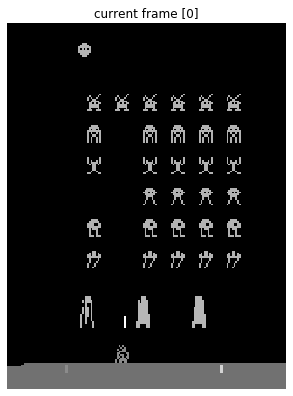

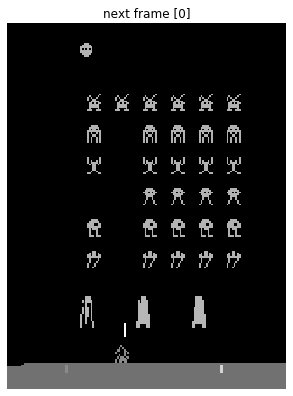

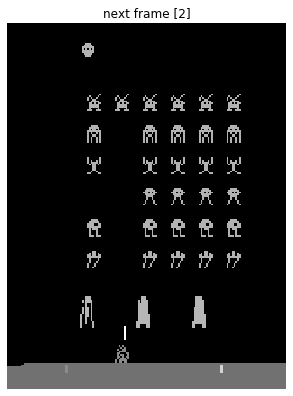

In [95]:
#get some information from  the batch to make sure it looks good.

import matplotlib.pyplot as plt

frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)

print("action: {}".format(actions_batch[0]))
print("reward: {}".format(reward_batch[0]))
print("frame:  {}".format(frame_number_batch[0]))

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("current frame [0]")
plt.imshow(frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("current frame [2]")
# plt.imshow(frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("next frame [0]")
plt.imshow(next_frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("next frame [2]")
# plt.imshow(next_frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()